In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import praw
import os
from datetime import datetime
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ayoub\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Pyspark

In [34]:
import pyspark 
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType, ArrayType
from pyspark.sql.functions import col, window, sum, count, avg, explode

spark = SparkSession.builder.appName("test0").getOrCreate()
spark.conf.set("spark.sql.execution.arrow.enabled", "true")


df = spark.read.json("scraped_data/israel-palestine.json", multiLine=True)

comments_df = df.selectExpr("id as post_id","explode(comments) as comment") \
                .selectExpr("post_id", "comment.*") \
                .withColumn("timestamp", col("timestamp").cast(TimestampType())) \
                
posts_df = df[[column for column in df.columns if column != "comments"]] \
    .withColumn("timestamp", col("timestamp").cast(TimestampType())) \
                

comments_pd = comments_df.toPandas()
posts_pd = posts_df.toPandas()

In [36]:
comments_pd.head(3)

,post_id,id,label,text,timestamp,ups
0,175au9w,k4efycz,neutral,Israel pulled out of Gaza in 2005 so the 2010 ...,2023-10-11 11:56:11,1411
1,175au9w,k4eg0gi,with palestine,The 1946 map should be completely red as the w...,2023-10-11 11:56:49,833
2,175au9w,k4ees0u,with palestine,To be fair. You should count 1947 as the first...,2023-10-11 11:43:13,457


In [37]:
posts_pd.head(3)

,class,id,num_comments,preview,subreddit,text,timestamp,title,upvote_ratio,upvotes,url
0,,175au9w,682,https://external-preview.redd.it/35qaia1zr0YPI...,r/geopolitics,,2023-10-11 11:31:27,Is this Palestine-Israel map history accurate?,0.77,1060,https://solidarnost.su/wp-content/uploads/2015...
1,None,1c7lqqt,1375,https://external-preview.redd.it/mKqHVAGaLWiUI...,r/news,,2024-04-19 03:26:18,Israel missiles strike Iran - US officials inf...,0.94,11643,https://www.reuters.com/world/middle-east/isra...
2,None,1c3pjmi,1492,None,r/NoStupidQuestions,Aren't they Jewish? Don't they specifically NO...,2024-04-14 10:26:07,"Why do Christian nationalists support Israel, ...",0.77,6048,https://www.reddit.com/r/NoStupidQuestions/com...


In [41]:
posts_pd.to_csv("scraped_data/posts.csv", index=False)

In [84]:
comments_pd["label"].value_counts()

label
with palestine    9879
with israel       9450
neutral           4423
inquisitive       3708
indifferent        303
with iran            2
sad                  2
with                 2
with iceland         1
with lebanon         1
agree                1
humor                1
with iran            1
disappointed         1
with russia          1
sarcastic            1
Name: count, dtype: int64

In [91]:
comments_pd.groupby("label")["ups"].sum().reset_index().sort_values("ups", ascending=False)

,label,ups
12,with israel,4932739
14,with palestine,4296109
5,neutral,2030768
4,inquisitive,1582656
3,indifferent,100587
9,with iceland,4565
11,with iran,1072
8,with,875
6,sad,148
0,agree,144


In [87]:
comments_pd["day"] = comments_pd["timestamp"].dt.date
day_count = comments_pd[comments_pd["label"].isin(["with israel", "with palestine", "neutral"])] \
           .groupby(["label", "day"])["id"] \
           .count() \
           .reset_index()


In [88]:
import seaborn as sns

day_count["cumcount"] = day_count.groupby("label")["id"].cumsum()


<Axes: xlabel='day', ylabel='cumcount'>

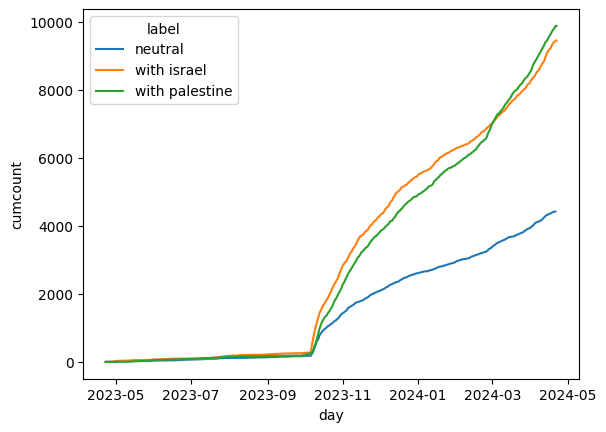

In [89]:
sns.lineplot(x="day", y="cumcount", data=day_count, hue="label")

In [2]:
comments_df = pd.read_csv("scraped_data/reddit_comments.csv")
comments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27777 entries, 0 to 27776
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   post_id    27777 non-null  object
 1   id         27777 non-null  object
 2   label      27777 non-null  object
 3   text       27777 non-null  object
 4   timestamp  27777 non-null  object
 5   ups        27777 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 1.3+ MB


In [8]:
labels = ["with israel", "with palestine", "neutral", "indifferent", "inquisitive"]
undesired_text = ["[ Removed by Reddit ]", "[supprimé]","[effacé]"] 
clean_df = comments_df[(comments_df.label.isin(labels)) & 
            (~comments_df.text.isin(undesired_text))]

In [13]:
clean_df.to_csv("scraped_data/reddit_comments_clean.csv", index=False)

In [5]:
import os
import praw
from datetime import datetime

client_id = os.environ.get('CLIENT_ID')
client_secret = os.environ.get('CLIENT_SECRET')
user_agent = "Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:47.0) Gecko/20100101 Firefox/47.0"
username = os.environ.get('REDDIT_USERNAME')
password = os.environ.get('REDDIT_PASSWORD')
reddit = praw.Reddit(client_id=client_id,
                    client_secret=client_secret,
                    user_agent=user_agent,
                    username=username,
                    password=password)

subreddit = reddit.subreddit("IsraelPalestine+worldnews")
start_date = datetime(2023, 11, 1)

for comment in subreddit.stream.comments():
    timestamp = datetime.fromtimestamp(comment.created_utc)
    print(f"""{
        "timestamp": {timestamp},
        "id": {comment.id},
        "text": {comment.body},
        "ups": {comment.ups},
        "downs": {comment.downs},
        "subreddit": {comment.subreddit.display_name}
    }"""
    )


ValueError: Invalid format specifier ' 2024-04-28 19:54:54,
        "id": l1ofll1,
        "text": >I mean that 45% of Palestinians in the West Bank support Hamas

I presume you are referring to their share of the vote in the 2005 Legislative Elections. I will point out that, based on that number, even back then more than half did not vote Hamas.

I'm sure their *current* support **in the Palestinian territories** is actually quite a bit higher than that though I don't have the most recent credible polling numbers. But then I liken this to Ukranians who may not have ordinarily wanted anything to do with the Azov Brigade (who are literal Nazis) suddenly supporting them once the Russian bombs began to fall.

Just to avoid any ambiguity, nothing in what I have said should be interpreted as support for Hamas or their tactics of seeking out civilian soft targets. All I am saying is that, for a people that feels under siege and occupation, I can understand why many among them will profess support for anyone they perceive to be fighting back on their behalf.

>In England, all the organisations I have been a part of, support Hamas

I live in England and I've been active in the pro Palestinian movement since the late 90s and I do not recognise your categorisation in the slightest! In what way do they support Hamas???

Everyone I have ever interacted with in the pro-Palestine movement has always been against the targeting of civilians on both sides.

Can you give me some specific examples of the pro Hamas support you claim to have encountered?,
        "ups": 1,
        "downs": 0,
        "subreddit": IsraelPalestine
    ' for object of type 'str'